In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import interpolate
from scipy.stats import norm
import torch
from itertools import chain
from torch.utils.data import TensorDataset, DataLoader

from lib.encoder_back_gru import Encoder_Back_GRU
import lib.Metrics as Metrics
from lib.hhs_data_builder import DataConstructor, convert_to_torch
# from lib.encoders import 
from torch import nn
import lib.encoders as encoders
from torchdiffeq import odeint
import lib.train_functions as train_functions
import lib.utils as utils
from lib.UONN import FaFp
from lib.models import Decoder, Fa, Fp
from torch.distributions import Categorical, Normal
from lib.VAE import VAE
from filelock import FileLock

In [45]:
import torch
import torch.nn as nn
from torch.distributions import Normal

class FaFp(nn.Module):
    def __init__(self, n_region=1, latent_dim=8, nhidden=20, aug_net_sizes=[32, 32]):
        super(FaFp, self).__init__()

        self.n_region = n_region
        self.latent_dim = latent_dim
        self.ode_type = 'FaFp'

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_region*latent_dim, nhidden),
            nn.ELU(inplace=True),
            nn.Linear(nhidden, nhidden),
            nn.ELU(inplace=True),
            nn.Linear(nhidden, 2*n_region),
        )

        self.aug_net = nn.ModuleList()
        self.aug_net.append(nn.Flatten())
        self.aug_net.append(nn.Linear(n_region * latent_dim, aug_net_sizes[0]))
        for l in range(1, len(aug_net_sizes)):
            self.aug_net.append(nn.ELU(inplace=True))
            self.aug_net.append(nn.Linear(aug_net_sizes[l - 1], aug_net_sizes[l]))
        self.aug_net.append(nn.Linear(aug_net_sizes[-1], 3 * n_region))
        
        self.params = []
        self.tracker = []

    def forward(self, t, x):
        out_of_range_mask = (x > 2) | (x < -1)
        out = torch.abs(self.net(x)).reshape(-1, self.n_region, 2)
        
        self.params.append(out)

        plusI = out[..., 0] * x[..., 0] * x[..., 1]
        minusI = out[..., 1] * x[..., 1]

        Fp = torch.stack([-plusI, plusI - minusI, minusI], dim=-1)
        
        out_aug = self.flatten(x)
        for layer in self.aug_net:
            out_aug = layer(out_aug)
        Fa = out_aug.reshape(-1, self.n_regions, 3)
        res = torch.cat([Fp + Fa, torch.zeros_like(x[..., 3:])], -1)

        res[out_of_range_mask] = 0.0
        self.tracker.append(Fa)
        self.params.append(out)

        return res
    
    def clear_tracking(self):
        """Resets the trackers."""
        self.params = []
    
    def posterior(self):
        params = torch.stack(self.params).reshape(-1, 2)
        
        self.params = []
        return Normal(params.mean(0), params.std(0))

In [7]:
started = []
for ode_name in ['CONN', 'SONN', 'UONN']:
    for num in range(1,6):
        for test_season in [2015, 2016, 2017, 2018]:
            file_prefix = f'weights/{ode_name}/{region}_{num}_{test_season}_'
            if any([file_prefix.split('/')[-1] in f for f in os.listdir(f'weights/{ode_name}/')]):
                started.append(file_prefix)

# started_file_path = "HHS_started.txt"  # Replace with the desired file path
# with open(started_file_path, 'w') as file:
#     for item in started:
#         file.write("%s\n" % item)

In [10]:
n_qs = 9
latent_dim = 8
n_regions = 10
num = 1
test_season = 2018
_data = DataConstructor(test_season=test_season, region = region, window_size=window_size, n_queries=n_qs, gamma=28)
x_train, y_train, x_test, y_test, scaler = _data(run_backward=True, no_qs_in_output=True)

train_loader, x_test, y_test = convert_to_torch(x_train, y_train, x_test, y_test, batch_size=32, shuffle=True, dtype=torch.float32)  

In [48]:
file_prefix = 'weights/CONN/hhs_5_2018_'

enc_file = f'{file_prefix}chkpt_enc.pth'
ode_file = f'{file_prefix}chkpt_ode.pth'
dec_file = f'{file_prefix}chkpt_dec.pth'

model = VAE(Encoder_Back_GRU, FaFp, Decoder, n_qs, latent_dim, n_regions, file_prefix=file_prefix)

model.enc.load_state_dict(torch.load(enc_file))
model.dec.load_state_dict(torch.load(dec_file))
missing_keys = model.ode.load_state_dict(torch.load(ode_file), strict=False)

print("Layers with missing weights:")
for layer in missing_keys:
    print(f" - {layer}")

Layers with missing weights:
 - ['aug_net.1.weight', 'aug_net.1.bias', 'aug_net.3.weight', 'aug_net.3.bias', 'aug_net.4.weight', 'aug_net.4.bias']
 - []


In [41]:
ode_name = 'UONN'
for num in range(1, 6):
    ode = {'CONN':Fp, 'UONN':FaFp, 'SONN':Fa}[ode_name]

    file_prefix = f'weights/{ode_name}/{region}_{num}_{test_season}_'
    model = VAE(Encoder_Back_GRU, ode, Decoder, n_qs, latent_dim, n_regions, file_prefix=file_prefix)
    model.load(checkpoint=True)  

    y_pred = model(x_test, t, n_samples=128)
    y_pr = y_pred.detach().numpy() * scaler.values[np.newaxis, np.newaxis, np.newaxis, :]
    y_te = y_test.detach().numpy() * scaler.values[np.newaxis, np.newaxis, :]

    pred_mean = y_pr.mean(1)
    pred_std = y_pr.std(1)

    results = {'ground_truth':y_te.tolist(),
            'mean':pred_mean.tolist(),
            'std': pred_std.tolist(),
            }

    skills = pd.DataFrame(index = [7,14,21,28], columns = [2015,2016,2017,2018], dtype=float)
    for g_tr, g in zip([7,14,21,28], [-22,-15,-8,-1]):
        skills.loc[g_tr, test_season] = np.exp(np.mean(Metrics.mb_log(y_te[:, g, :], pred_mean[:, g, :], pred_std[:, g, :]))).astype(float)
    print(np.exp(np.mean(np.log(skills), 1)))

7     0.099030
14    0.097579
21    0.095607
28    0.093282
dtype: float64
7     0.225936
14    0.207045
21    0.187055
28    0.167649
dtype: float64
7     0.186859
14    0.179705
21    0.169824
28    0.158100
dtype: float64
7     0.148393
14    0.145647
21    0.142876
28    0.140259
dtype: float64
7     0.193129
14    0.186097
21    0.174748
28    0.160173
dtype: float64


In [ ]:
7     0.373126
14    0.307039
21    0.264656
28    0.242970

In [69]:
n_samples = 16
dtype = torch.float32
device = 'cpu'
x_tr = x_train[:batch_size]

eps = torch.randn(n_samples, batch_size, n_regions, latent_dim-1, dtype=dtype, device=device)
ode.clear_tracking()
# optimizer.zero_grad()

mean, std = enc(x_tr)
z = encoders.reparam(eps, std, mean, n_samples, batch_size)
latent = odeint(ode, z, t, method='rk4', options=dict(step_size = 1.0))
y_pred = dec(latent[..., :3]).reshape((-1, n_samples, batch_size, n_regions)).permute(2,1,0,3)

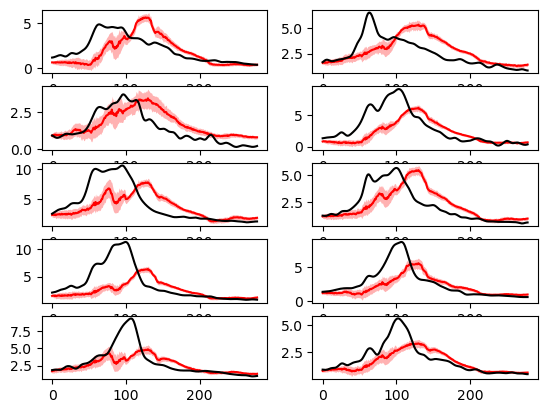

In [14]:
g = -1
for hhs in range(1,11):
    plt.subplot(5, 2, hhs)
    plt.plot(pred_mean[:, g, -hhs], color='red')
    plt.fill_between(np.arange(y_te.shape[0]), 
                     (pred_mean-pred_std)[:, g, -hhs], 
                     (pred_mean+pred_std)[:, g, -hhs], 
                     linewidth = 0,
                     alpha=0.3,
                     color='red')
    plt.plot(y_te[:, g, -hhs], color='black')
    # plt.ylim([0,4.5])
plt.show()

In [7]:
import torch
import torch.nn as nn
from torch.distributions import Normal

class FaFp(nn.Module):
    def __init__(self, n_regions=1, latent_dim=8, net_sizes=[32, 32], aug_net_sizes=[32, 32], nhidden_fa=32):
        super(FaFp, self).__init__()
        self.n_regions = n_regions
        self.latent_dim = latent_dim
        self.flatten = nn.Flatten()
            
        self.net = nn.ModuleList()
        self.net.append(nn.Linear(n_regions * latent_dim, net_sizes[0]))
        for l in range(1, len(net_sizes)):
            self.net.append(nn.ELU(inplace=True))
            self.net.append(nn.Linear(net_sizes[l - 1], net_sizes[l]))
        self.net.append(nn.Linear(net_sizes[-1], 2 * n_regions))

        self.aug_net = nn.ModuleList()
        self.aug_net.append(nn.Linear(n_regions * latent_dim, aug_net_sizes[0]))
        for l in range(1, len(aug_net_sizes)):
            self.aug_net.append(nn.ELU(inplace=True))
            self.aug_net.append(nn.Linear(aug_net_sizes[l - 1], aug_net_sizes[l]))
        self.aug_net.append(nn.Linear(aug_net_sizes[-1], 3 * n_regions))

        self.params = []
        self.tracker = []

    def forward(self, t, x):
        out_of_range_mask = (x > 2) | (x < -1)

        # Applying layers in self.net sequentially
        out = self.flatten(x)
        
        for layer in self.net:
            out = layer(out)
        out = torch.abs(out).reshape(-1, self.n_regions, 2)
        
        plusI = out[..., 0] * x[..., 0] * x[..., 1]
        minusI = out[..., 1] * x[..., 1]

        # Applying layers in self.aug_net sequentially
        Fp = torch.stack([-plusI, plusI - minusI, minusI], dim=-1)
        out_aug = self.flatten(x)
        for layer in self.aug_net:
            out_aug = layer(out_aug)
        Fa = out_aug.reshape(-1, self.n_regions, 3)
        
        res = torch.cat([Fp + Fa, torch.zeros_like(x[..., 3:])], -1)

        res[out_of_range_mask] = 0.0
        self.tracker.append(Fa)
        self.params.append(out)

        return res

    def clear_tracking(self):
        self.params = []
        self.tracker = []

    def posterior(self):
        params = torch.stack(self.params).reshape(-1, 2)
        self.params = []
        return Normal(params.mean(0), params.std(0))


In [8]:
def reparam(eps, std, mean, n_samples, batch_size):
    z = eps * std + mean
    z = torch.concat([torch.abs(z[..., :2]), (1 - torch.abs(z[..., :2]).sum(-1)).unsqueeze(-1), z[..., 2:]], -1)
    z = z.reshape((n_samples * batch_size, ) + z.shape[2:])
    return z

def make_prior(mean, z_prior=torch.tensor([0.1, 0.01]), device='cpu', latent_dim=8):
    z_prior=z_prior.to(device)
    mean_concat = torch.cat((mean[..., :2]  , torch.zeros_like(mean[..., 2:], device=device)), dim=-1)
    std = torch.cat([z_prior[0].unsqueeze(0), z_prior[1].unsqueeze(0), torch.ones(latent_dim - len(z_prior) - 1, device=device)], 0).expand_as(mean_concat)

    return Normal(mean_concat, torch.abs(std))